In [6]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.layers import Dense, Input, LSTM
from keras.models import Model
import numpy as np
import tensorflow as tf
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from typing import List
from tqdm import tqdm

In [7]:
LATENT_DIM = 512
PAST_LEN = 20
FUTURE_LEN = 100
N_STATES = 9
N_PATCHES = 2
PATH = Path('../data/processed/two_patches_bis')

In [8]:
def create_model(latent_dim=LATENT_DIM, past_len=PAST_LEN, future_len=FUTURE_LEN, n_states=N_STATES, n_patches=N_PATCHES):
    encoder_inputs = Input(shape=(past_len, n_states * n_patches))
    encoder = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)

    decoder_inputs = Input(shape=(future_len, n_patches))
    decoder_lstm = LSTM(latent_dim, return_sequences=True)
    x = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
    x = Dense(512, activation='relu')(x)
    output = Dense(n_states*n_patches, activation="relu")(x)

    return Model([encoder_inputs, decoder_inputs], output)

In [9]:
model = create_model()
model.compile(optimizer="adam", loss="mean_squared_error")

In [10]:
future = np.load(PATH/'future.npy')
past = np.load(PATH/'past.npy')
strat = np.load(PATH/'release_strategy.npy')

In [11]:
population_scaler = MinMaxScaler(feature_range=(0, 1))
population_scaler.fit(np.concatenate(np.concatenate([future, past], axis=1), axis=0))

future = np.apply_along_axis(lambda x: population_scaler.transform(x.reshape(1, -1))[0], axis=2, arr=future)
past = np.apply_along_axis(lambda x: population_scaler.transform(x.reshape(1, -1))[0], axis=2, arr=past)


In [12]:
strat_scaler = MinMaxScaler(feature_range=(0, 1))
strat_scaler.fit(np.concatenate(strat, axis=0))

strat = np.apply_along_axis(lambda x: strat_scaler.transform(x.reshape(1, -1))[0], axis=2, arr=strat)

In [13]:
model.fit([past, strat], future, epochs=100, batch_size=20, validation_split=0.2)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - loss: 0.0463 - val_loss: 0.0288
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - loss: 0.0234 - val_loss: 0.0186
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - loss: 0.0107 - val_loss: 0.0081
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - loss: 0.0076 - val_loss: 0.0082
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - loss: 0.0083 - val_loss: 0.0069
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 409ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 388ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━

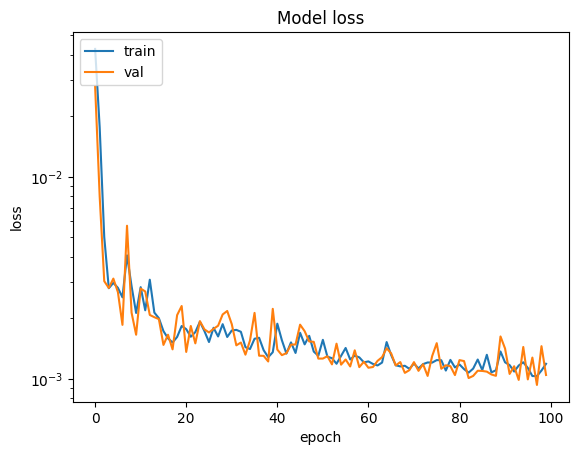

In [11]:
history = model.history
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.yscale("log")
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:

mask = tf.cast(tf.range(FUTURE_LEN) % 7 == 0, tf.float32)
mask_tf = tf.reshape(mask, (1, FUTURE_LEN, 1))

@tf.function
def get_cost_and_grad(a_latent: tf.Variable, b_latent: tf.Variable) -> tuple[tf.Tensor, List[tf.Tensor]]:

    with tf.GradientTape() as tape:
        tape.watch([a_latent, b_latent])

        # Reparameterization: Transform latent vars to (0, 1) range
        a = tf.sigmoid(a_latent)
        b = tf.sigmoid(b_latent)
        col_a = mask_tf * a
        col_b = mask_tf * b

        past_tf = tf.convert_to_tensor(past[0:1, :PAST_LEN, :])
        strat_tf = tf.reshape(tf.concat([col_a, col_b], axis=1), (1, FUTURE_LEN, 2))
        prediction = model([past_tf, strat_tf])

        # Use the cost function from your example
        cost = tf.math.reduce_sum(prediction[0, -1, :N_STATES-1]) + tf.math.reduce_sum(prediction[0, -1, N_STATES+1:]) + 0.3 * (tf.multiply(a, a) + tf.multiply(b, b))
    # 5. Calculate gradients
    grads = tape.gradient(cost, [a_latent, b_latent])
    return cost, grads, a, b # Return cost, grads, and constrained values

In [50]:
a_latent = tf.Variable(1.)
b_latent = tf.Variable(1.)

# Setup optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
num_epochs = 200

# Print initial *constrained* values
print(f"Initial values: a={tf.sigmoid(a_latent).numpy():.4f}, b={tf.sigmoid(b_latent).numpy():.4f}")


# Store history for plotting
history = {'cost': [], 'a': [], 'b': []}

for epoch in tqdm(range(num_epochs)):
    # Calculate cost and gradients
    cost, [grad_a, grad_b], a_val, b_val = get_cost_and_grad(a_latent, b_latent)

    # Apply gradients to the *latent* variables
    optimizer.apply_gradients(zip([grad_a, grad_b], [a_latent, b_latent]))

    history['cost'].append(cost.numpy())
    history['a'].append(a_val.numpy())
    history['b'].append(b_val.numpy())

Initial values: a=0.7311, b=0.7311


100%|██████████| 200/200 [00:05<00:00, 39.85it/s]


In [52]:
strat_scaler.inverse_transform([[a_val, b_val]])[0]

array([10308.87254436, 21678.39880738])

In [48]:
np.max(np.load(PATH/'release_strategy.npy'))

np.float64(59950.2270254772)

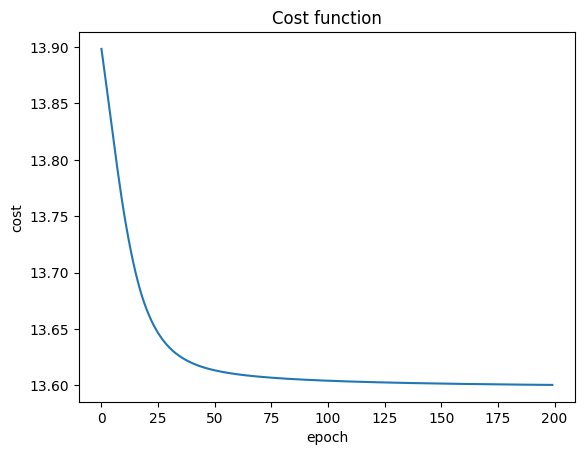

In [34]:
plt.plot(history["cost"])
plt.title("Cost function")
plt.ylabel("cost")
plt.xlabel('epoch')
plt.show()